## Setup and Import Libraries

In [1]:
import os
from typing import Literal, List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_tavily import TavilySearch
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain.schema import Document
from langchain import hub
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langgraph.graph import END, StateGraph, START
from dotenv import load_dotenv

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [2]:
load_dotenv()

True

In [3]:
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

In [4]:
embeddings = OpenAIEmbeddings()
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

## Create Retriever

In [5]:
def create_retriever(urls, chunk_size=500, chunk_overlap=50):
    # Load Documents
    documents = [WebBaseLoader(url).load() for url in urls]
    documents_list = [item for document in documents for item in document]

    # Perform Splitting
    text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        chunk_size=chunk_size, chunk_overlap=chunk_overlap
    )
    chunks = text_splitter.split_documents(documents=documents_list)

    # Add to Vector Store
    vector_store = FAISS.from_documents(
        documents=chunks,
        embedding=embeddings
    )

    return vector_store.as_retriever()

In [7]:
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

retriever = create_retriever(urls=urls, chunk_size=500, chunk_overlap=50)
retriever

VectorStoreRetriever(tags=['FAISS', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x0000028B396822D0>, search_kwargs={})

## Creating Router

In [10]:
class RouteQuery(BaseModel):
    """ 
    Route a user query to the most relevant datasource
    """
    
    datasource: Literal["vectorstore", "web_search"] = Field(
        ...,
        description="Given a user question choose to route it to web search or a vectorstore."
    )

In [11]:
structured_llm_router = llm.with_structured_output(schema=RouteQuery)

In [12]:
route_system_prompt = """You are an expert at routing a user question to a vectorstore or web search.
The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.
Use the vectorstore for questions on these topics. Otherwise, use web-search."""


route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", route_system_prompt),
        ("human", "{question}"),
    ]
)

In [13]:
question_router = route_prompt | structured_llm_router

question_router_result = question_router.invoke(input={
    "question": "Who won the Cricket world cup 2023"
})

print(question_router_result)

datasource='web_search'


In [14]:
question_router_result = question_router.invoke(input={
    "question": "What are the types of agent memory?"
})

print(question_router_result)

datasource='vectorstore'


## Create Retrieval Grader

In [15]:
class GradeDocuments(BaseModel):
    """
    Binary score for relevance check on retrieved documents.
    """

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

In [16]:
structured_llm_grader = llm.with_structured_output(schema=GradeDocuments)

In [17]:
grade_system_prompt = """You are a grader assessing relevance of a retrieved document to a user question.
If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant.
It does not need to be a stringent test. The goal is to filter out erroneous retrievals.
Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""

grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", grade_system_prompt),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

In [18]:
retrieval_grader = grade_prompt | structured_llm_grader

In [ ]:
question = "agent memory"

documents = retriever.invoke(input=question)
documents_text = documents[1].page_content

print(retrieval_grader.invoke({"question": question, "document": documents_text}))

binary_score='yes'


## Generate

In [ ]:
prompt = hub.pull("rlm/rag-prompt")

# Post-processing
def format_docs(documents):
    return "\n\n".join(document.page_content for document in documents)

# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke(input={"context": documents, "question": question})
print(generation)

Agent memory in LLM-powered autonomous agents consists of short-term and long-term memory. Short-term memory is utilized for in-context learning, while long-term memory allows agents to retain and recall information over extended periods, often using an external vector store for fast retrieval. This dual memory system enhances the agent's ability to learn from past experiences and improve future performance.


## Hallucination Grader

In [22]:
class GradeHallucinations(BaseModel):
    """
    Binary score for hallucination present in generation answer.
    """

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )

In [23]:
structured_llm_hallucination_grader = llm.with_structured_output(schema=GradeHallucinations)

In [24]:
hallucination_system_prompt = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts.
     Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""

hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", hallucination_system_prompt),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

In [25]:
hallucination_grader = hallucination_prompt | structured_llm_hallucination_grader

hallucination_grader.invoke(input={"documents": documents, "generation": generation})

GradeHallucinations(binary_score='yes')

## Answer Grader

In [26]:
class GradeAnswer(BaseModel):
    """
    Binary score to assess answer addresses question.
    """

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )

In [27]:
structured_llm_answer_grader = llm.with_structured_output(schema=GradeAnswer)

In [28]:
answer_grader_system_prompt = """You are a grader assessing whether an answer addresses / resolves a question
Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""

answer_grader_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", answer_grader_system_prompt),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

In [29]:
answer_grader = answer_grader_prompt | structured_llm_answer_grader

answer_grader.invoke({"question": question, "generation": generation})

GradeAnswer(binary_score='yes')

## Question Re-writer

In [30]:
question_rewriter_system_prompt = """You a question re-writer that converts an input question to a better version that is optimized \n 
     for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""

question_rewriter_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", question_rewriter_system_prompt),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

In [31]:
question_rewriter = question_rewriter_prompt | llm | StrOutputParser()

question_rewriter.invoke({"question": question})

'What are the key concepts and techniques related to agent memory in artificial intelligence?'

## Web Search Tool

In [32]:
web_search_tool = TavilySearch(max_results=3)

## Graph State

In [33]:
class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]

## Nodes

In [34]:
def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    documents = retriever.invoke(input=question)
    return {"documents": documents, "question": question}

In [35]:
def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke(input={"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}

In [36]:
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            input={"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs, "question": question}

In [37]:
def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    improved_question = question_rewriter.invoke(input={"question": question})
    return {"documents": documents, "question": improved_question}

In [45]:
def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["question"]

    # Web search
    documents = web_search_tool.invoke(input={"query": question})
    
    web_results = "\n".join([document["content"] for document in documents['results']])
    web_results = Document(page_content=web_results)

    return {"documents": web_results, "question": question}

## Edges

In [46]:
def route_question(state):
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke(input={"question": question})

    if source.datasource == "web_search":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "web_search"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"

In [47]:
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

In [48]:
def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        input={"documents": documents, "generation": generation}
    )
    grade = score.binary_score

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

## Create Graph

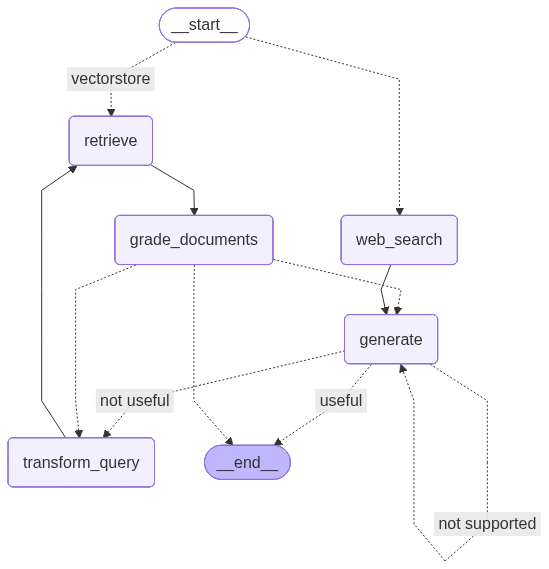

In [49]:
workflow = StateGraph(GraphState)

# Add Nodes
workflow.add_node(node="web_search", action=web_search)  # web search
workflow.add_node(node="retrieve", action=retrieve)  # retrieve
workflow.add_node(node="grade_documents", action=grade_documents)  # grade documents
workflow.add_node(node="generate", action=generate)  # generate
workflow.add_node(node="transform_query", action=transform_query)  # transform_query

# Add Edges
workflow.add_conditional_edges(
    source=START,
    path=route_question,
    path_map={
        "web_search": "web_search",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge(start_key="web_search", end_key="generate")
workflow.add_edge(start_key="retrieve", end_key="grade_documents")
workflow.add_conditional_edges(
    source="grade_documents",
    path=decide_to_generate,
    path_map={
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge(start_key="transform_query", end_key="retrieve")
workflow.add_conditional_edges(
    source="generate",
    path=grade_generation_v_documents_and_question,
    path_map={
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
    },
)

# Compile Graph
graph = workflow.compile()

graph

In [50]:
question = "What is Machine Learning"

graph.invoke({"question":question})

---ROUTE QUESTION---
---ROUTE QUESTION TO WEB SEARCH---
---WEB SEARCH---
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---


{'question': 'What is Machine Learning',
 'generation': 'Machine learning (ML) is a subfield of artificial intelligence that involves training algorithms on data sets to create models capable of making predictions or generating content. These models learn patterns from the training data and can perform tasks such as categorizing images or predicting outcomes without human intervention. Essentially, ML enables software to improve its performance on specific tasks by learning from data.',
 'documents': Document(metadata={}, page_content="* Machine learning (ML) is a way to train software, called a model, to make predictions or generate content using data. * Generative AI creates new content, such as text, images, or music, by learning patterns from existing data and mimicking them. In basic terms, ML is the process of training a piece of software, called a model, to make useful predictions or generate content (like text, images, audio, or video) from data. Unsupervised learning models ma

In [51]:
question = "What is agent memory"

graph.invoke({"question":question})

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---


{'question': 'What is agent memory',
 'generation': 'Agent memory refers to the mechanisms by which an autonomous agent retains and recalls information. It includes short-term memory, which utilizes in-context learning, and long-term memory, which allows for the retention of information over extended periods through external storage systems. This memory structure enables agents to improve their performance by learning from past experiences and refining their actions.',
 'documents': [Document(id='bb072e22-4cfa-41b8-a19e-85e72c536b02', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as